### <span style="color: lightskyblue;"> Creación de Samples X y labels Y </span>

In [32]:
import pandas as pd

# Columnas necesarias
cols = ['fecha_origen_recorrido', 'fecha_destino_recorrido', 
        'id_estacion_origen', 'id_estacion_destino']

# Tipos optimizados
dtype = {
    'id_estacion_origen': 'string',
    'id_estacion_destino': 'string'
}

parse_dates = ['fecha_origen_recorrido', 'fecha_destino_recorrido']

trips = pd.read_csv('data/raw/trips_2022.csv', usecols=cols, dtype=dtype, parse_dates=parse_dates)


In [33]:
station_ids = pd.Index(
    pd.concat([trips['id_estacion_origen'], trips['id_estacion_destino']])
    .dropna()
    .unique()
)
station_ids = station_ids.sort_values()


In [34]:
import pandas as pd
import numpy as np

delta_T = pd.Timedelta(minutes=30)

# Paso 1: Agregamos columnas de ventana temporal (inicio de bloque de 30 min)
trips['ventana_origen'] = trips['fecha_origen_recorrido'].dt.floor('30min')
trips['ventana_destino'] = trips['fecha_destino_recorrido'].dt.floor('30min')

# Paso 2: Reunimos todos los IDs de estación ordenados
station_ids = pd.Index(
    pd.concat([trips['id_estacion_origen'], trips['id_estacion_destino']])
    .unique()
).sort_values()


# Paso 3: Conteo de partidas (X)
X_df = (
    trips.groupby(['ventana_origen', 'id_estacion_origen'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=station_ids, fill_value=0)
)

# Paso 4: Conteo de arribos (Y)
Y_df = (
    trips.groupby(['ventana_destino', 'id_estacion_destino'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=station_ids, fill_value=0)
)

# Paso 5: Alinear X y Y → el Y de cada fila es el arribo en la ventana siguiente
X_df = X_df.sort_index()
Y_df = Y_df.sort_index()

# Solo nos quedamos con ventanas que tienen su siguiente definida
common_index = X_df.index.intersection(Y_df.index - delta_T)
X_df = X_df.loc[common_index]
Y_df = Y_df.loc[common_index + delta_T]

# Paso 6: Convertimos a arrays finales
X = X_df.values.astype('int16')
Y = Y_df.values.astype('int16')
timestamps = X_df.index.to_series()


In [35]:
np.savez_compressed('data/processed/dataset_XY_bicis.npz', X=X, Y=Y, timestamps=timestamps.to_numpy())

In [36]:
# Previsualizar X e Y guardados
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Timestamps shape:", timestamps.shape)
print("Estaciones únicas:", len(station_ids))
print("Estaciones:", station_ids.tolist())
print("Primeras 5 filas de X:\n", X[:5])
print("Primeras 5 filas de Y:\n", Y[:5])

X shape: (17506, 334)
Y shape: (17506, 334)
Timestamps shape: (17506,)
Estaciones únicas: 334
Estaciones: ['101BAEcobici', '102BAEcobici', '104BAEcobici', '107BAEcobici', '111BAEcobici', '112BAEcobici', '114BAEcobici', '116BAEcobici', '117BAEcobici', '118BAEcobici', '120BAEcobici', '121BAEcobici', '122BAEcobici', '124BAEcobici', '126BAEcobici', '128BAEcobici', '12BAEcobici', '130BAEcobici', '131BAEcobici', '132BAEcobici', '134BAEcobici', '135BAEcobici', '137BAEcobici', '138BAEcobici', '13BAEcobici', '144BAEcobici', '146BAEcobici', '149BAEcobici', '14BAEcobici', '150BAEcobici', '151BAEcobici', '152BAEcobici', '153BAEcobici', '155BAEcobici', '156BAEcobici', '158BAEcobici', '161BAEcobici', '162BAEcobici', '163BAEcobici', '164BAEcobici', '165BAEcobici', '166BAEcobici', '167BAEcobici', '168BAEcobici', '169BAEcobici', '171BAEcobici', '172BAEcobici', '174BAEcobici', '175BAEcobici', '176BAEcobici', '177BAEcobici', '179BAEcobici', '17BAEcobici', '181BAEcobici', '182BAEcobici', '183BAEcobici', '

El dato de (i,j) de la matriz X indica el número de partidas desde la estación j en la ventana temporal i.

### <span style="color: lightskyblue;"> Modelo 1: XG-Boost -> Entrenamiento por ventana </span>

In [37]:
from sklearn.model_selection import train_test_split

# División en train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [38]:
%pip install xgboost

In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = []
predictions = []
rmse_list = []
mae_list = []
r2_list = []

for j in range(Y.shape[1]):
    y_train_j = Y_train[:, j]
    y_test_j = Y_test[:, j]

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='reg:squarederror',
        verbosity=0,
        n_jobs=-1,
    )
    model.fit(X_train, y_train_j)
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test_j, y_pred, squared=False)
    mae = mean_absolute_error(y_test_j, y_pred)
    r2 = r2_score(y_test_j, y_pred)
    
    models.append(model)
    predictions.append(y_pred)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)


c:\Users\TizianoD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\TizianoD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\TizianoD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\TizianoD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: 

In [41]:
Y_pred = np.stack(predictions, axis=1)  # (n_samples, n_estaciones)

In [42]:

naive_pred = Y_test[:-1]
naive_rmse = mean_squared_error(Y_test[1:], naive_pred, squared=False)
print(f"Naive RMSE (predice el valor anterior): {naive_rmse:.2f}")


Naive RMSE (predice el valor anterior): 1.07


c:\Users\TizianoD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

global_rmse = mean_squared_error(Y_test, Y_pred, squared=False)
print(f"\n🌎 RMSE global (todas las estaciones): {global_rmse:.2f}")
global_mae = mean_absolute_error(Y_test, Y_pred)
print(f"🌎 MAE global (todas las estaciones): {global_mae:.2f}")
global_r2 = r2_score(Y_test, Y_pred)
print(f"🌎 R2 global (todas las estaciones): {global_r2:.2f}")



🌎 RMSE global (todas las estaciones): 0.80
🌎 MAE global (todas las estaciones): 0.52
🌎 R2 global (todas las estaciones): 0.19


c:\Users\TizianoD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


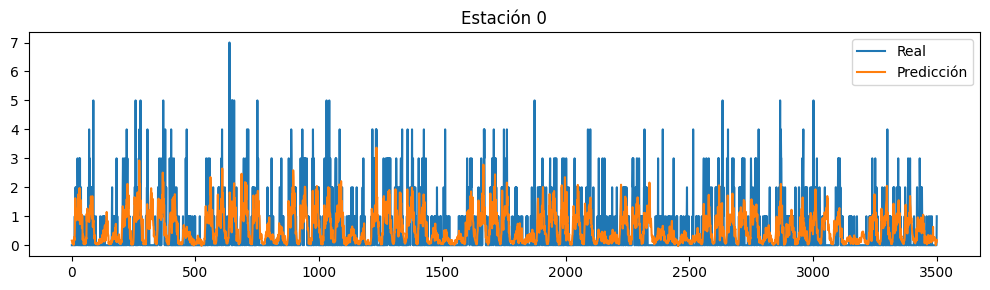

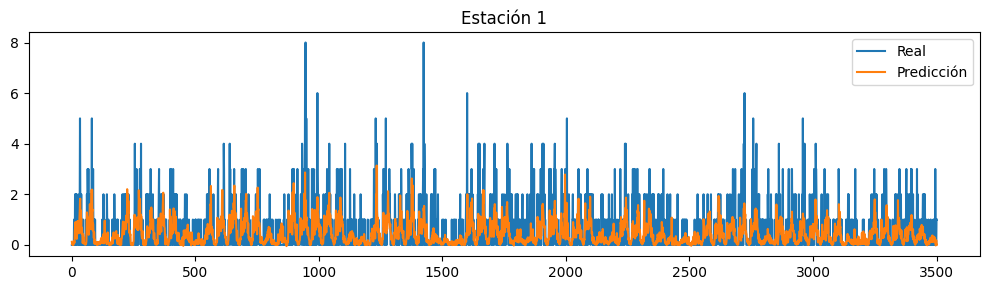

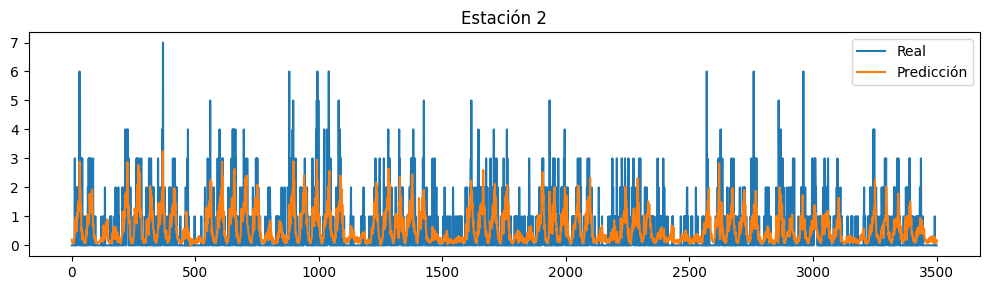

In [44]:
import matplotlib.pyplot as plt

estaciones_para_ver = [0, 1, 2]  # podés elegir otras
for j in estaciones_para_ver:
    plt.figure(figsize=(10, 3))
    plt.plot(Y_test[:, j], label='Real')
    plt.plot(Y_pred[:, j], label='Predicción')
    plt.title(f'Estación {j}')
    plt.legend()
    plt.tight_layout()
    plt.show()
